In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint, uniform, gauss
import math

In [3]:
C_train = 60000
alpha = 0.37
error_all = 0.5

X_train = []
y_train = []
for i in range(C_train):
    xi = uniform(0, 3)
    sigmai = uniform(0.1, 2)
    error_now = abs(gauss(0, error_all))
    
    xi1 = math.exp(alpha * xi)
    sigmai1 = ((alpha * xi1)**2 * sigmai**2 + error_now**2) ** 0.5
    X_train.append([xi, sigmai**2])
    y_train.append([xi1, sigmai1**2])

X_train = torch.tensor(X_train).view(-1, 2)
y_train = torch.tensor(y_train).view(-1, 2)


In [4]:
backbone = nn.Sequential(nn.Linear(2, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU())

head_x = nn.Linear(32, 1)
head_sigma = nn.Linear(32, 1)
softplus = nn.Softplus()

params = list(backbone.parameters()) + list(head_x.parameters()) + list(head_sigma.parameters())
opt = optim.Adam(params, lr=10**(-3))

In [5]:
batch = 1024
epochs = 50

for k in range(epochs):
    pos = torch.randperm(X_train.size(0))
    ans = 0
    cnt = 0
    for i in range(0, X_train.size(0), batch):
        ind = pos[i:i + batch]
        x_now = X_train[ind]
        y_now = y_train[ind]

        res = backbone(x_now)
        x = head_x(res)
        sigma = softplus(head_sigma(res))

        x_ok = y_now[:, [0]]
        sigma_ok = y_now[:, [1]]

        loss = ((x - x_ok) ** 2).mean() + ((sigma - sigma_ok) ** 2).mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        ans += loss.item()
        cnt += 1

    print("iter ", k + 1, ", loss = ", ans/cnt, sep='')


iter 1, loss = 2.294452810691575
iter 2, loss = 0.5529034738823518
iter 3, loss = 0.33437766766144056
iter 4, loss = 0.2103269501762875
iter 5, loss = 0.1608954827159138
iter 6, loss = 0.14895532204438064
iter 7, loss = 0.14398492026632115
iter 8, loss = 0.14091687636860348
iter 9, loss = 0.13886388176578587
iter 10, loss = 0.13771402886358358
iter 11, loss = 0.13685727157330108
iter 12, loss = 0.13579199791459715
iter 13, loss = 0.13482990115880966
iter 14, loss = 0.13434041556665452
iter 15, loss = 0.13350082226728988
iter 16, loss = 0.13267818611052076
iter 17, loss = 0.13225454395100222
iter 18, loss = 0.13176715437133432
iter 19, loss = 0.13141671606039595
iter 20, loss = 0.13097867028693022
iter 21, loss = 0.13115230770939487
iter 22, loss = 0.1308399498210115
iter 23, loss = 0.13077251789933544
iter 24, loss = 0.1301802303326332
iter 25, loss = 0.13027864884016876
iter 26, loss = 0.13011720258805712
iter 27, loss = 0.12968563162169214
iter 28, loss = 0.1295700448296838
iter 29, 

In [6]:
C_test = 10000
X_test = []
y_test = []
for i in range(C_test):
    xi = uniform(0, 3)
    sigmai = uniform(0.1, 2)
    error_now = abs(gauss(0, error_all))
    
    xi1 = math.exp(alpha * xi)
    sigmai1 = ((alpha * xi1)**2 * sigmai**2 + error_now**2) ** 0.5
    X_test.append([xi, sigmai**2])
    y_test.append([xi1, sigmai1**2])

X_test = torch.tensor(X_test).view(-1, 2)
y_test = torch.tensor(y_test).view(-1, 2)

mse_error = 0
mse_x = 0
for i in range(C_test):
    h = backbone(X_test[i])
    xi1 = head_x(h)
    sigmai1 = softplus(head_sigma(h))
    mse_error += (y_test[i][1] - sigmai1) ** 2
    mse_x += (y_test[i][0] - xi1) ** 2
mse_error /= C_test
mse_x /= C_test
print("MSE sigma =", mse_error.item())
print("MSE x = ", mse_x.item())

MSE sigma = 0.12072587758302689
MSE x =  0.00016801572928670794


In [7]:
import numpy as np
import matplotlib.pyplot as plt

C_iter = 30
col_test = 1000

need_x = [0.0] * (C_iter + 1)
need_sigma = [0.0] * (C_iter + 1)
res_x  = [0.0] * (C_iter + 1)
res_sigma = [0.0] * (C_iter + 1)

sum_error_x = [0] * (C_iter + 1)
sum_error_sigma = [0] * (C_iter + 1)

for iter1 in range(col_test):
    x0 = uniform(0, 1.5)
    sigma0 = uniform(0.2, 1)

    x = torch.tensor([[x0]], dtype=torch.float32)
    sigma = torch.tensor([[sigma0 ** 2]], dtype=torch.float32)
    x_true = torch.tensor([[x0]], dtype=torch.float32)
    sigma_true = torch.tensor([[sigma0 ** 2]], dtype=torch.float32)

    need_x[0] += x0
    need_sigma[0] += sigma0**2
    res_x[0] += x0
    res_sigma[0] += sigma0**2

    for i in range(C_iter):
        error_now = error_all ** 2
        xii1 = torch.exp(alpha * x_true)
        sigmai1 = ((alpha * xii1)**2) * sigma_true + error_now
        need_x[i + 1] += xii1.item()
        need_sigma[i + 1] += sigmai1.item()
        x_true = xii1
        sigma_true = sigmai1

        now = torch.cat([x, sigma], dim=1)
        h = backbone(now)
        x = softplus(head_x(h))
        sigma = softplus(head_sigma(h))
        res_x[i + 1] += x.item()
        res_sigma[i + 1] += sigma.item()

        sum_error_x[i + 1] += (x_true.item() - x.item()) ** 2
        sum_error_sigma[i + 1] += (sigma_true.item() - sigma.item()) ** 2

for i in range(C_iter + 1):
    need_x[i] /= col_test
    need_sigma[i] /= col_test
    res_x[i] /= col_test
    res_sigma[i] /= col_test

    sum_error_x[i] /= col_test
    sum_error_sigma[i] /= col_test

need_x = np.array(need_x)
need_sigma = np.sqrt(np.array(need_sigma))
res_x = np.array(res_x)
res_sigma = np.sqrt(np.array(res_sigma))

sum_error_x = np.array(sum_error_x)
sum_error_sigma = np.array(sum_error_sigma)
print(sum_error_sigma)

[0.00000000e+00 2.94164717e-04 9.49035783e-04 5.18245741e-03
 1.93782495e-02 4.86487429e-02 1.04297231e-01 2.08940504e-01
 3.88835562e-01 6.94380306e-01 1.27767099e+00 2.43111615e+00
 4.77334556e+00 9.23793521e+00 1.54273824e+01 1.78026853e+01
 1.93673239e+01 2.12918869e+01 2.34383361e+01 2.58638530e+01
 2.86123342e+01 3.17372549e+01 3.53001734e+01 3.93718678e+01
 4.40555280e+01 4.95001041e+01 5.58226511e+01 6.31684529e+01
 7.16947766e+01 8.15671916e+01 9.29485509e+01]


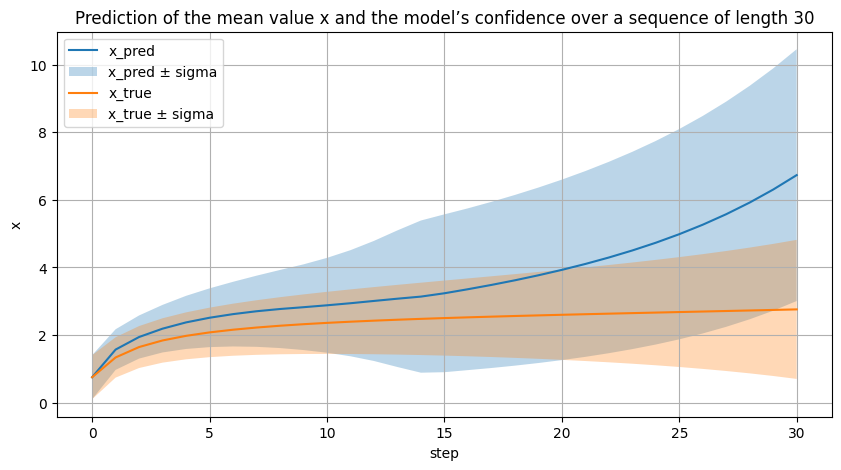

In [8]:
need_x = np.array(need_x)
need_sigma = np.array(need_sigma)
res_x = np.array(res_x)
res_sigma = np.array(res_sigma)
steps = np.array(list(range(C_iter + 1)))
plt.figure(figsize=(10, 5))
plt.xlabel("step")
plt.title("Prediction of the mean value x and the model’s confidence over a sequence of length 30")
plt.ylabel("x")
plt.plot(steps, res_x, label = "x_pred")
plt.fill_between(steps, res_x - res_sigma, res_x + res_sigma, alpha=0.3, label = "x_pred ± sigma")
plt.plot(steps, need_x, label = "x_true")
plt.fill_between(steps, need_x - need_sigma, need_x + need_sigma, alpha=0.3, label = "x_true ± sigma")
plt.grid()
plt.legend()
plt.show()

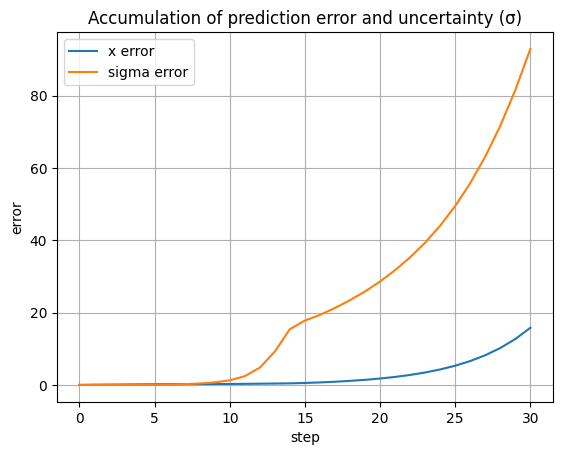

In [10]:
steps = np.array(list(range(C_iter + 1)))
plt.xlabel("step")
plt.ylabel("error")
plt.title("Accumulation of prediction error and uncertainty (σ)")
plt.plot(steps, sum_error_x, label="x error")
plt.plot(steps, sum_error_sigma, label="sigma error")
plt.grid()
plt.legend()
plt.show()